In [217]:
import pandas as pd
import random
import numpy as np
import pickle
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data
import shap
import requests

In [410]:
team_data = pd.read_pickle(r'final_df')
past_games = pd.read_pickle(r'old_data')

#past_games = past_games.apply(pd.to_numeric, errors='coerce')
team_data = team_data.reset_index(drop = True)
team_data
past_games_short = past_games[past_games['Season'] >= 2011]
past_games_short

,Season,WScore,LScore,Team 1,Team 2,Win?
868,2011,60,58,Old Dominion,Butler,L
661,2011,76,69,North Carolina,Kentucky,L
732,2011,71,70,Pittsburgh,Butler,L
1030,2011,74,51,UNC Asheville,Pittsburgh,L
1034,2011,65,43,St Peter's,Purdue,L
...,...,...,...,...,...,...
687,2019,78,77,New Mexico St,Auburn,L
402,2019,61,51,Texas Tech,Michigan St,W
946,2019,62,58,Kentucky,Houston,W
942,2019,78,58,Texas Tech,Buffalo,W


In [416]:
team_data

,Year,Team,2P,3P,3P%,FT,ORB,TRB,AST,STL,BLK,TOV,PF,PTS,stdvarPER,Weight TS%,SOS,Pyth,Guard Usage,Weeks Ranked
0,2011,UNC Asheville,3.8,-1.5,-0.010,1.9,-1.1,-0.9,1.8,1.7,0.9,-2.5,-0.8,5.1,0.449565,54.374163,-2.89,0.765526,24.4,0
1,2012,UNC Asheville,1.9,-0.3,0.006,6.5,-1.1,-1.2,1.9,1.7,-0.5,-2.5,-3.6,9.3,0.710946,59.855014,-2.71,0.882909,24.8,0
2,2016,UNC Asheville,2.2,-0.3,0.032,3.6,1.0,2.2,1.4,2.4,0.8,-2.4,-2.4,7.1,0.302857,55.784326,-3.25,0.837353,27.1,0
3,2011,Texas,2.7,1.1,0.081,4.1,1.9,6.3,4.0,0.5,2.2,-1.0,-3.7,12.8,1.166701,54.143084,20.82,0.956382,29.1,17
4,2012,Texas,1.9,-0.1,-0.020,2.3,1.3,-0.5,1.2,1.0,0.3,-1.0,-1.5,5.8,1.140905,53.320079,8.12,0.797997,29.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2018,Lipscomb,0.2,0.6,-0.013,2.3,1.7,3.3,2.2,-0.6,-1.3,-0.6,-1.7,4.4,2.457480,56.394805,-3.80,0.712768,29.6,0
608,2019,Colgate,0.8,1.2,0.057,0.1,-0.1,3.6,2.5,-1.0,0.3,0.9,-1.0,5.5,1.447717,57.486824,-3.83,0.776362,27.4,0
609,2019,Abilene Chr,2.5,1.8,0.050,-0.2,0.9,0.3,4.9,3.1,0.0,-4.5,1.3,10.0,0.422864,57.261883,-7.34,0.917550,18.0,0
610,2019,Gardner Webb,3.3,-0.9,0.065,3.2,-3.5,-1.1,0.9,0.9,0.0,-1.8,-1.1,7.2,1.310355,59.878928,-4.43,0.832647,27.1,0


In [415]:

model_data_2 = pd.DataFrame()
for i in range(len(past_games)):

    year =   past_games.iloc[i,:]['Season']
    team_1 = past_games.iloc[i,:]['Team 1']
    team_2 = past_games.iloc[i,:]['Team 2']



    team_1_data = team_data[(team_data['Team'] == team_1)&(team_data['Year'] == year)]
    team_2_data = team_data[(team_data['Team'] == team_2)&(team_data['Year'] == year)]
    
    team_1_data = team_1_data.reset_index(drop = True)
    team_2_data = team_2_data.reset_index(drop = True)
    
    team_1_data.iloc[:,2:] = team_1_data.iloc[:,2:].apply(pd.to_numeric, errors='coerce')
    team_2_data.iloc[:,2:] = team_2_data.iloc[:,2:].apply(pd.to_numeric, errors='coerce')
    
    var_list = ['2P',
                   'FT',
                   'ORB',
                    'TRB',
                    'AST',
                    'STL',
                    'BLK',
                    'TOV',
                    'PF',
                    'PTS',
                    'stdvarPER',
                    'Weight TS%',
                    'Pyth',
                    'Guard Usage','3P','3P%','SOS', 'Weeks Ranked']
    
    model_data_2 = model_data_2.append(team_1_data[var_list].subtract(team_2_data[var_list]))
    
    #team_1_data = team_1_data.reset_index(drop = True)
    #team_2_data = team_2_data.reset_index(drop = True)



model_data_2.insert(0,"Year",list(past_games_short['Season']))
model_data_2.insert(1,"Team 1",list(past_games_short['Team 1']))
model_data_2.insert(2,"Team 2",list(past_games_short['Team 2']))

#model_data_1['Win'] = list(past_games['Win?'])

# model_data = model_data_1.merge(model_data_2, 
#                                   right_on = ['Year','Team 1','Team 2'],
#                                   left_on = ['Year','Team 1','Team 2'])

#make win binary

model_data_2.insert(21,"Win", list(past_games_short['Win?']))

conds_1 = [(model_data_2['Win'] == 'W'),(model_data_2['Win'] == 'L')]
actions_1 = [1, 0]
model_data_2['Win'] = np.select(conds_1,actions_1)



model_data_2 = model_data_2.dropna()
model_data_2

,Year,Team 1,Team 2,2P,FT,ORB,TRB,AST,STL,BLK,...,PTS,stdvarPER,Weight TS%,Pyth,Guard Usage,3P,3P%,SOS,Weeks Ranked,Win
0,2011,Old Dominion,Butler,4.4,2.8,3.7,8.7,0.7,0.5,2.6,...,0.1,-1.134472,-2.298686,0.022113,-5.6,-3.9,-0.065,-3.26,-2.0,0
0,2011,North Carolina,Kentucky,2.9,3.4,1.5,2.7,1.0,-1.5,-0.4,...,-2.7,0.938321,-3.657277,-0.061407,-4.9,-4.0,-0.076,-1.43,-9.0,0
0,2011,Pittsburgh,Butler,3.9,2.3,1.8,7.7,4.8,-0.8,0.5,...,5.8,-3.072694,2.394137,0.109675,-5.4,-1.6,0.041,15.80,17.0,0
0,2011,UNC Asheville,Pittsburgh,-0.5,-2.1,-5.0,-11.7,-4.1,1.9,1.7,...,-7.8,-0.169774,-1.963952,-0.193983,1.2,-1.5,-0.079,-23.71,-19.0,0
0,2011,St Peter's,Purdue,-0.8,-4.1,-2.3,-2.9,-2.5,0.2,-0.3,...,-9.8,-1.671574,-4.508933,-0.377050,-5.7,-1.2,0.000,-20.43,-19.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2019,New Mexico St,Auburn,2.2,1.7,5.2,10.8,3.9,-2.9,-0.5,...,2.7,1.715156,-1.208699,0.040346,0.6,-1.2,-0.032,-23.22,-14.0,0
0,2019,Texas Tech,Michigan St,2.1,-3.3,-1.7,-7.7,-2.4,2.1,0.1,...,0.7,-0.314780,-0.759345,0.016406,3.6,-0.1,0.005,-2.14,-3.0,1
0,2019,Kentucky,Houston,1.6,7.3,0.0,2.1,-2.3,-1.1,-0.4,...,-3.2,0.641574,2.840726,-0.038302,-1.8,-4.5,-0.065,2.52,5.0,1
0,2019,Texas Tech,Buffalo,3.8,-1.4,-4.0,-2.7,-2.5,-0.9,1.6,...,-0.3,0.724009,0.333961,0.017594,9.1,-2.1,0.028,7.23,-2.0,1


In [413]:
model_data_2 = model_data_2.merge(kenpom_df, left = )

Year            562
Team 1          562
Team 2          562
2P              562
FT              562
ORB             562
TRB             562
AST             562
STL             562
BLK             562
TOV             562
PF              562
PTS             562
stdvarPER       562
Weight TS%      562
Pyth            562
Guard Usage     562
3P              562
3P%             562
SOS             562
Weeks Ranked    562
Win             562
dtype: int64

In [370]:
y = model_data_2.iloc[:,-1]
X = model_data_2.iloc[:,3:-1]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   train_size = .8,
                                                   random_state = 69)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 323)
rf.fit(X_train, y_train)



invalid value encountered in reduce


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [365]:
predictions = rf.predict(X_test)

errors = abs(predictions - y_test)

errors.mean()



0.3950188679245283

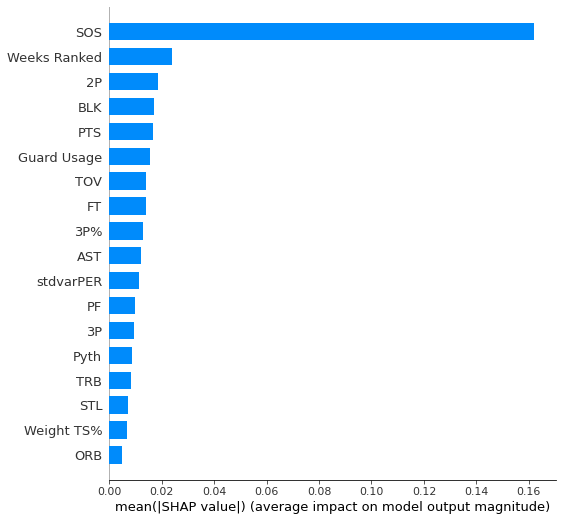

In [366]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_values
shap.summary_plot(shap_values, X_test, plot_type = "bar")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [187]:
x = pd.read_html('https://www.sportsoddshistory.com/cbb-main/?y=2018-2019&sa=cbb&a=nc&o=r')
x[0]

Team Preseason,as of...                  \
                 Team              Apr 3   Aug 1   Nov 6   
0            Virginia             1800.0    2000    1350   
1          Texas Tech             5000.0    6000    7000   
2      Michigan State             1800.0    2500    2650   
3              Auburn             3500.0    4000    4500   
4                Duke              600.0     550     450   
..                ...                ...     ...     ...   
347            Wagner                NaN  999999  999999   
348  Western Carolina                NaN  999999  999999   
349  Western Illinois                NaN  999999  999999   
350          Winthrop                NaN  999999  999999   
351  Youngstown State                NaN  999999  999999   

    Regular season,as of...                         Tournament,prior to...  \
                      Dec 1   Jan 1   Feb 1   Mar 1                Round 1   
0                    2000.0   950.0   900.0   800.0                  675.0   
1                    7000.0  4500.0  5000.0  2500.0                 2500.0   
2                    3300.0  1250.0  1600.0  1200.0                 1600.0   
3                    4000.0  3250.0  6500.0  6600.0                 5000.0   
4                     300.0   175.0   200.0   210.0                  255.0   
..                      ...     ...     ...     ...                    ...   
347                     NaN     NaN     NaN     NaN                    NaN   
348                     NaN     NaN     NaN     NaN                    NaN   
349                     NaN     NaN     NaN     NaN                    NaN   
350                     NaN     NaN     NaN     NaN                    NaN   
351                     NaN     NaN     NaN     NaN                    NaN   

                                                           Result  
    Round of 32 Sweet 16 Elite 8 Final 4 Natl Champ        Result  
0         485.0    420.0   365.0   158.0     -130.0  ** WINNER **  
1        2000.0   1700.0  1050.0   375.0      110.0           NaN  
2        1800.0   1400.0   665.0   215.0        NaN           NaN  
3        5000.0   4400.0  2350.0   660.0        NaN           NaN  
4         320.0    285.0   315.0     NaN        NaN           NaN  
..          ...      ...     ...     ...        ...           ...  
347         NaN      NaN     NaN     NaN        NaN           NaN  
348         NaN      NaN     NaN     NaN        NaN           NaN  
349         NaN      NaN     NaN     NaN        NaN           NaN  
350         NaN      NaN     NaN     NaN        NaN           NaN  
351         NaN      NaN     NaN     NaN        NaN           NaN  

[352 rows x 15 columns]

In [195]:
x[0] = x[0].fillna(999999)

new_df = pd.DataFrame()
new_df['Team'] = x[0]['Team']
new_df['Odds Shift'] = x[0]['Preseason,as of...'].iloc[:,2] - x[0]['Tournament,prior to...'].iloc[:,0]
new_df

,Team,Odds Shift
0,Virginia,675.0
1,Texas Tech,4500.0
2,Michigan State,1050.0
3,Auburn,-500.0
4,Duke,195.0
...,...,...
347,Wagner,0.0
348,Western Carolina,0.0
349,Western Illinois,0.0
350,Winthrop,0.0


In [381]:
a

,Team,AdjEm,O_rtg,D_rtg
0,Abilene Christian,-11.86,97.0,108.8
1,Air Force,-5.22,104.3,109.5
2,Akron 7,6.1,112.6,106.4
3,Alabama 3,13.08,105.3,92.2
4,Alabama A&M,-30.34,91.4,121.8
...,...,...,...,...
362,Wright St.,0.34,106.5,106.2
363,Wyoming,2.78,104.8,102.0
364,Xavier 11,16.7,115.7,99.0
365,Yale,1.01,106.2,105.2


The default value of regex will change from True to False in a future version.


,Year,Team,AdjEm,O_rtg,D_rtg,Seeds
2,2003,Alabama,14.6,110.3,95.7,10
9,2003,Arizona,26.8,115.6,88.8,1
10,2003,Arizona St.,16.49,113.9,97.4,10
16,2003,Auburn,13.63,107.7,94.1,10
17,2003,Austin Peay,2.65,100.7,98.0,13
...,...,...,...,...,...,...
362,2019,Wisconsin,21.94,110.4,88.5,5
363,2019,Wofford,20.69,118.1,97.4,7
364,2019,Wright St.,5.02,107.1,102.0,7
366,2019,Xavier,10.6,111.1,100.5,3


In [431]:



kenpom_df[kenpom_df['Team'] == 'Arizona']

,Year,Team,AdjEm,O_rtg,D_rtg,Seeds,Kaggle
13,2003,Arizona,26.8,115.6,88.8,1,Arizona
14,2004,Arizona,16.18,118.5,102.3,9,Arizona
15,2005,Arizona,22.22,116.7,94.5,3,Arizona
16,2006,Arizona,17.23,112.2,95.0,8,Arizona
17,2007,Arizona,19.43,119.5,100.1,8,Arizona
18,2008,Arizona,19.14,116.4,97.3,10,Arizona
19,2009,Arizona,15.96,117.7,101.8,12,Arizona
20,2011,Arizona,19.65,117.4,97.8,5,Arizona
21,2012,Arizona,12.77,107.6,94.9,1,Arizona
22,2013,Arizona,21.88,115.4,93.5,6,Arizona
